<a href="https://colab.research.google.com/github/aymuos/masters-practise-repo/blob/main/TERM2/ML_Lab/Project/industrial-ai-project/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Soumya Mukherjee  | CH24M571 | Project 

In [25]:
%pip install imbalanced-learn catboost xgboost

Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

In [27]:
raw_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

raw_data = raw_data.drop(['id'],axis=1)
test_data = test_data.drop(['id'],axis=1)

id: This column likely represents a unique identifier for each patient or observation in the dataset.

N_Days: This column represents the number of days for which the data was collected or observed for each patient.

Drug: This column likely represents the type of drug or treatment that the patient was given.

Age: This column represents the age of the patient.

Sex: This column represents the sex of the patient,
typically coded as 0 for female and 1 for male.

Ascites: This column represents the presence or absence of ascites, which is the accumulation of fluid in the abdominal cavity. It is likely coded as 0 for absent and 1 for present.

Hepatomegaly: This column represents the presence or absence of hepatomegaly, which is the enlargement of the liver. It is likely coded as 0 for absent and 1 for present.

Spiders: This column represents the presence or absence of spider angiomas, which are small blood vessels that appear on the skin. It is likely coded as 0 for absent and 1 for present.

Edema: This column represents the presence or absence of edema, which is the swelling of tissues due to the accumulation of fluid. It is likely coded as 0 for absent and 1 for present.

Bilirubin: This column represents the level of bilirubin in the patient's blood, which is a measure of liver function.

Cholesterol: This column represents the level of cholesterol in the patient's blood.

Albumin: This column represents the level of albumin in the patient's blood, which is a measure of liver function.

Copper: This column represents the level of copper in the patient's blood.

Alk_Phos: This column represents the level of alkaline phosphatase in the patient's blood, which is a measure of liver function.

SGOT: This column represents the level of serum glutamic-oxaloacetic transaminase in the patient's blood, which is a measure of liver function.

Tryglicerides: This column represents the level of triglycerides in the patient's blood.

Platelets: This column represents the number of platelets in the patient's blood.

Prothrombin: This column represents the prothrombin time, which is a measure of the time it takes for the blood to clot.

Stage: This column likely represents the stage or severity of the patient's liver disease.

Status: This column likely represents the outcome or status of the patient, such as alive or dead.


In [28]:
numerical_cols = raw_data.select_dtypes(include=['number']).columns
categorical_cols = raw_data.select_dtypes(exclude=['number']).columns

print(numerical_cols,'\n')
print(categorical_cols)

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object') 

Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status'], dtype='object')


In [29]:
print(raw_data.shape)
raw_data.isnull().sum()

(15000, 19)


N_Days              0
Drug             6551
Age                 0
Sex                 0
Ascites          6541
Hepatomegaly     6550
Spiders          6553
Edema               0
Bilirubin           0
Cholesterol      8337
Albumin             0
Copper           6640
Alk_Phos         6555
SGOT             6556
Tryglicerides    8385
Platelets         577
Prothrombin        18
Stage               0
Status              0
dtype: int64

In [30]:
print(test_data.shape)
test_data.isnull().sum()

(10000, 18)


N_Days              0
Drug             4284
Age                 0
Sex                 0
Ascites          4282
Hepatomegaly     4287
Spiders          4289
Edema               0
Bilirubin           0
Cholesterol      5547
Albumin             0
Copper           4358
Alk_Phos         4291
SGOT             4292
Tryglicerides    5581
Platelets         363
Prothrombin        16
Stage               0
dtype: int64

Status is missing in the output . hidden

In [31]:
# raw_data.describe()

In [32]:
# # finding unique values in each columns


unique_test = pd.DataFrame({
    'Column': test_data.columns,
    'Test Unique': [test_data[col].nunique() for col in test_data.columns]
})

unique_raw = pd.DataFrame({
    'Column': raw_data.columns,
    'Train Unique': [raw_data[col].nunique() for col in raw_data.columns]
})

# Merging the two tables on 'Column' - this is similar to SQL joins
unique_combined = pd.merge(unique_raw, unique_test, on='Column', how='outer')

print("Unique value counts for train and test data side by side:")
print(unique_combined)


Unique value counts for train and test data side by side:
           Column  Train Unique  Test Unique
0             Age           384        374.0
1         Albumin           164        164.0
2        Alk_Phos           382        350.0
3         Ascites             2          2.0
4       Bilirubin           116        115.0
5     Cholesterol           212        208.0
6          Copper           175        165.0
7            Drug             3          2.0
8           Edema             3          3.0
9    Hepatomegaly             2          2.0
10         N_Days           552        510.0
11      Platelets           262        255.0
12    Prothrombin            50         52.0
13           SGOT           202        195.0
14            Sex             2          2.0
15        Spiders             2          2.0
16          Stage             4          4.0
17         Status             3          NaN
18  Tryglicerides           153        152.0


Pre-processing data

In [33]:
processable_data = raw_data.copy(deep=True)
print(processable_data.shape)

td_copy = test_data.copy(deep = True)
print(td_copy.shape)

(15000, 19)
(10000, 18)


In [34]:
columns_to_binary_encode = ['Ascites', 'Hepatomegaly', 'Spiders','Edema']

# Perform binary encoding
for column in columns_to_binary_encode:

    processable_data[column] = processable_data[column].map({'N': 0, 'Y': 1, np.nan: -1 , 'S':2})
    td_copy[column] = td_copy[column].map({'N': 0, 'Y': 1, np.nan: -1 , 'S':2})

    # Optionally, drop the original categorical column
    # processable_data.drop(column, axis=1, inplace=True)

In [35]:
processable_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,1702.0,Placebo,18806.0,F,0,0,0,0,0.6,310.0,3.85,58.0,4332.0,43.40,112.0,273.0,10.6,3.0,C
1,2157.0,Placebo,22646.0,F,0,1,0,0,0.8,255.0,4.14,15.0,1758.0,106.95,172.0,514.0,10.0,3.0,C
2,1831.0,D-penicillamine,20483.0,F,0,0,0,0,0.8,256.0,3.85,20.0,646.0,57.00,84.0,204.0,9.9,3.0,C
3,971.0,NaN,22646.0,F,-1,-1,-1,0,3.0,NaN,3.03,NaN,NaN,NaN,NaN,258.0,11.8,4.0,D
4,1368.0,NaN,21915.0,F,-1,-1,-1,0,0.8,NaN,3.94,NaN,NaN,NaN,NaN,402.0,10.5,4.0,C


In [36]:
td_copy.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2844.0,NaN,19724.0,F,-1,-1,-1,0,0.9,NaN,3.24,NaN,NaN,NaN,NaN,330.0,10.5,3.0
1,2504.0,D-penicillamine,23612.0,M,0,0,0,0,0.6,217.0,3.87,20.0,666.0,54.25,68.0,270.0,11.2,4.0
2,1072.0,NaN,14245.0,F,-1,-1,-1,0,1.0,NaN,3.01,NaN,NaN,NaN,NaN,244.0,10.5,2.0
3,1725.0,NaN,12053.0,F,-1,-1,-1,0,2.2,NaN,3.76,NaN,NaN,NaN,NaN,418.0,9.9,3.0
4,130.0,Placebo,20535.0,F,0,1,0,0,1.3,NaN,3.82,58.0,601.0,60.45,NaN,265.0,11.5,4.0


In [37]:
# performing imputations

# Columns to mean impute
columns_to_impute = ['Bilirubin', 'Cholesterol', 'Albumin', 'SGOT', 'Platelets']

# Calculate the mean for each column
for column in columns_to_impute:
    mean_value = processable_data[column].mode()

    # Impute missing values with the mean
    processable_data[column] = processable_data[column].fillna(mean_value)
    td_copy[column] = td_copy[column].fillna(mean_value)


In [38]:
processable_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,1702.0,Placebo,18806.0,F,0,0,0,0,0.6,310.0,3.85,58.0,4332.0,43.40,112.0,273.0,10.6,3.0,C
1,2157.0,Placebo,22646.0,F,0,1,0,0,0.8,255.0,4.14,15.0,1758.0,106.95,172.0,514.0,10.0,3.0,C
2,1831.0,D-penicillamine,20483.0,F,0,0,0,0,0.8,256.0,3.85,20.0,646.0,57.00,84.0,204.0,9.9,3.0,C
3,971.0,NaN,22646.0,F,-1,-1,-1,0,3.0,NaN,3.03,NaN,NaN,NaN,NaN,258.0,11.8,4.0,D
4,1368.0,NaN,21915.0,F,-1,-1,-1,0,0.8,NaN,3.94,NaN,NaN,NaN,NaN,402.0,10.5,4.0,C


In [39]:
# doing KNN imputation for numerical columns

# Create KNN imputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Perform imputation on numerical columns
processable_data[numerical_cols] = imputer.fit_transform(processable_data[numerical_cols])
td_copy[numerical_cols] = imputer.transform(td_copy[numerical_cols])

# Encode 'Sex' column
processable_data['Sex'] = processable_data['Sex'].map({'M': 0, 'F': 1})
td_copy['Sex'] = td_copy['Sex'].map({'M': 0, 'F': 1})

# Encode 'Drug'
processable_data['Drug'] = processable_data['Drug'].astype('category').cat.codes   # this assigns unique numerical code to each distinct category
td_copy['Drug'] = td_copy['Drug'].astype('category').cat.codes

# Encode 'Status'
processable_data['Status'] = processable_data['Status'].map({'C': 0, 'D': 1, 'CL': 2})
# test data has no status - to be predicted

In [40]:
processable_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,1702.0,2,18806.0,1,0,0,0,0,0.6,310.0,3.85,58.0,4332.0,43.40,112.0,273.0,10.6,3.0,0
1,2157.0,2,22646.0,1,0,1,0,0,0.8,255.0,4.14,15.0,1758.0,106.95,172.0,514.0,10.0,3.0,0
2,1831.0,0,20483.0,1,0,0,0,0,0.8,256.0,3.85,20.0,646.0,57.00,84.0,204.0,9.9,3.0,0
3,971.0,-1,22646.0,1,-1,-1,-1,0,3.0,392.6,3.03,52.0,1207.0,100.61,167.6,258.0,11.8,4.0,1
4,1368.0,-1,21915.0,1,-1,-1,-1,0,0.8,387.4,3.94,137.6,1654.8,119.97,119.6,402.0,10.5,4.0,0


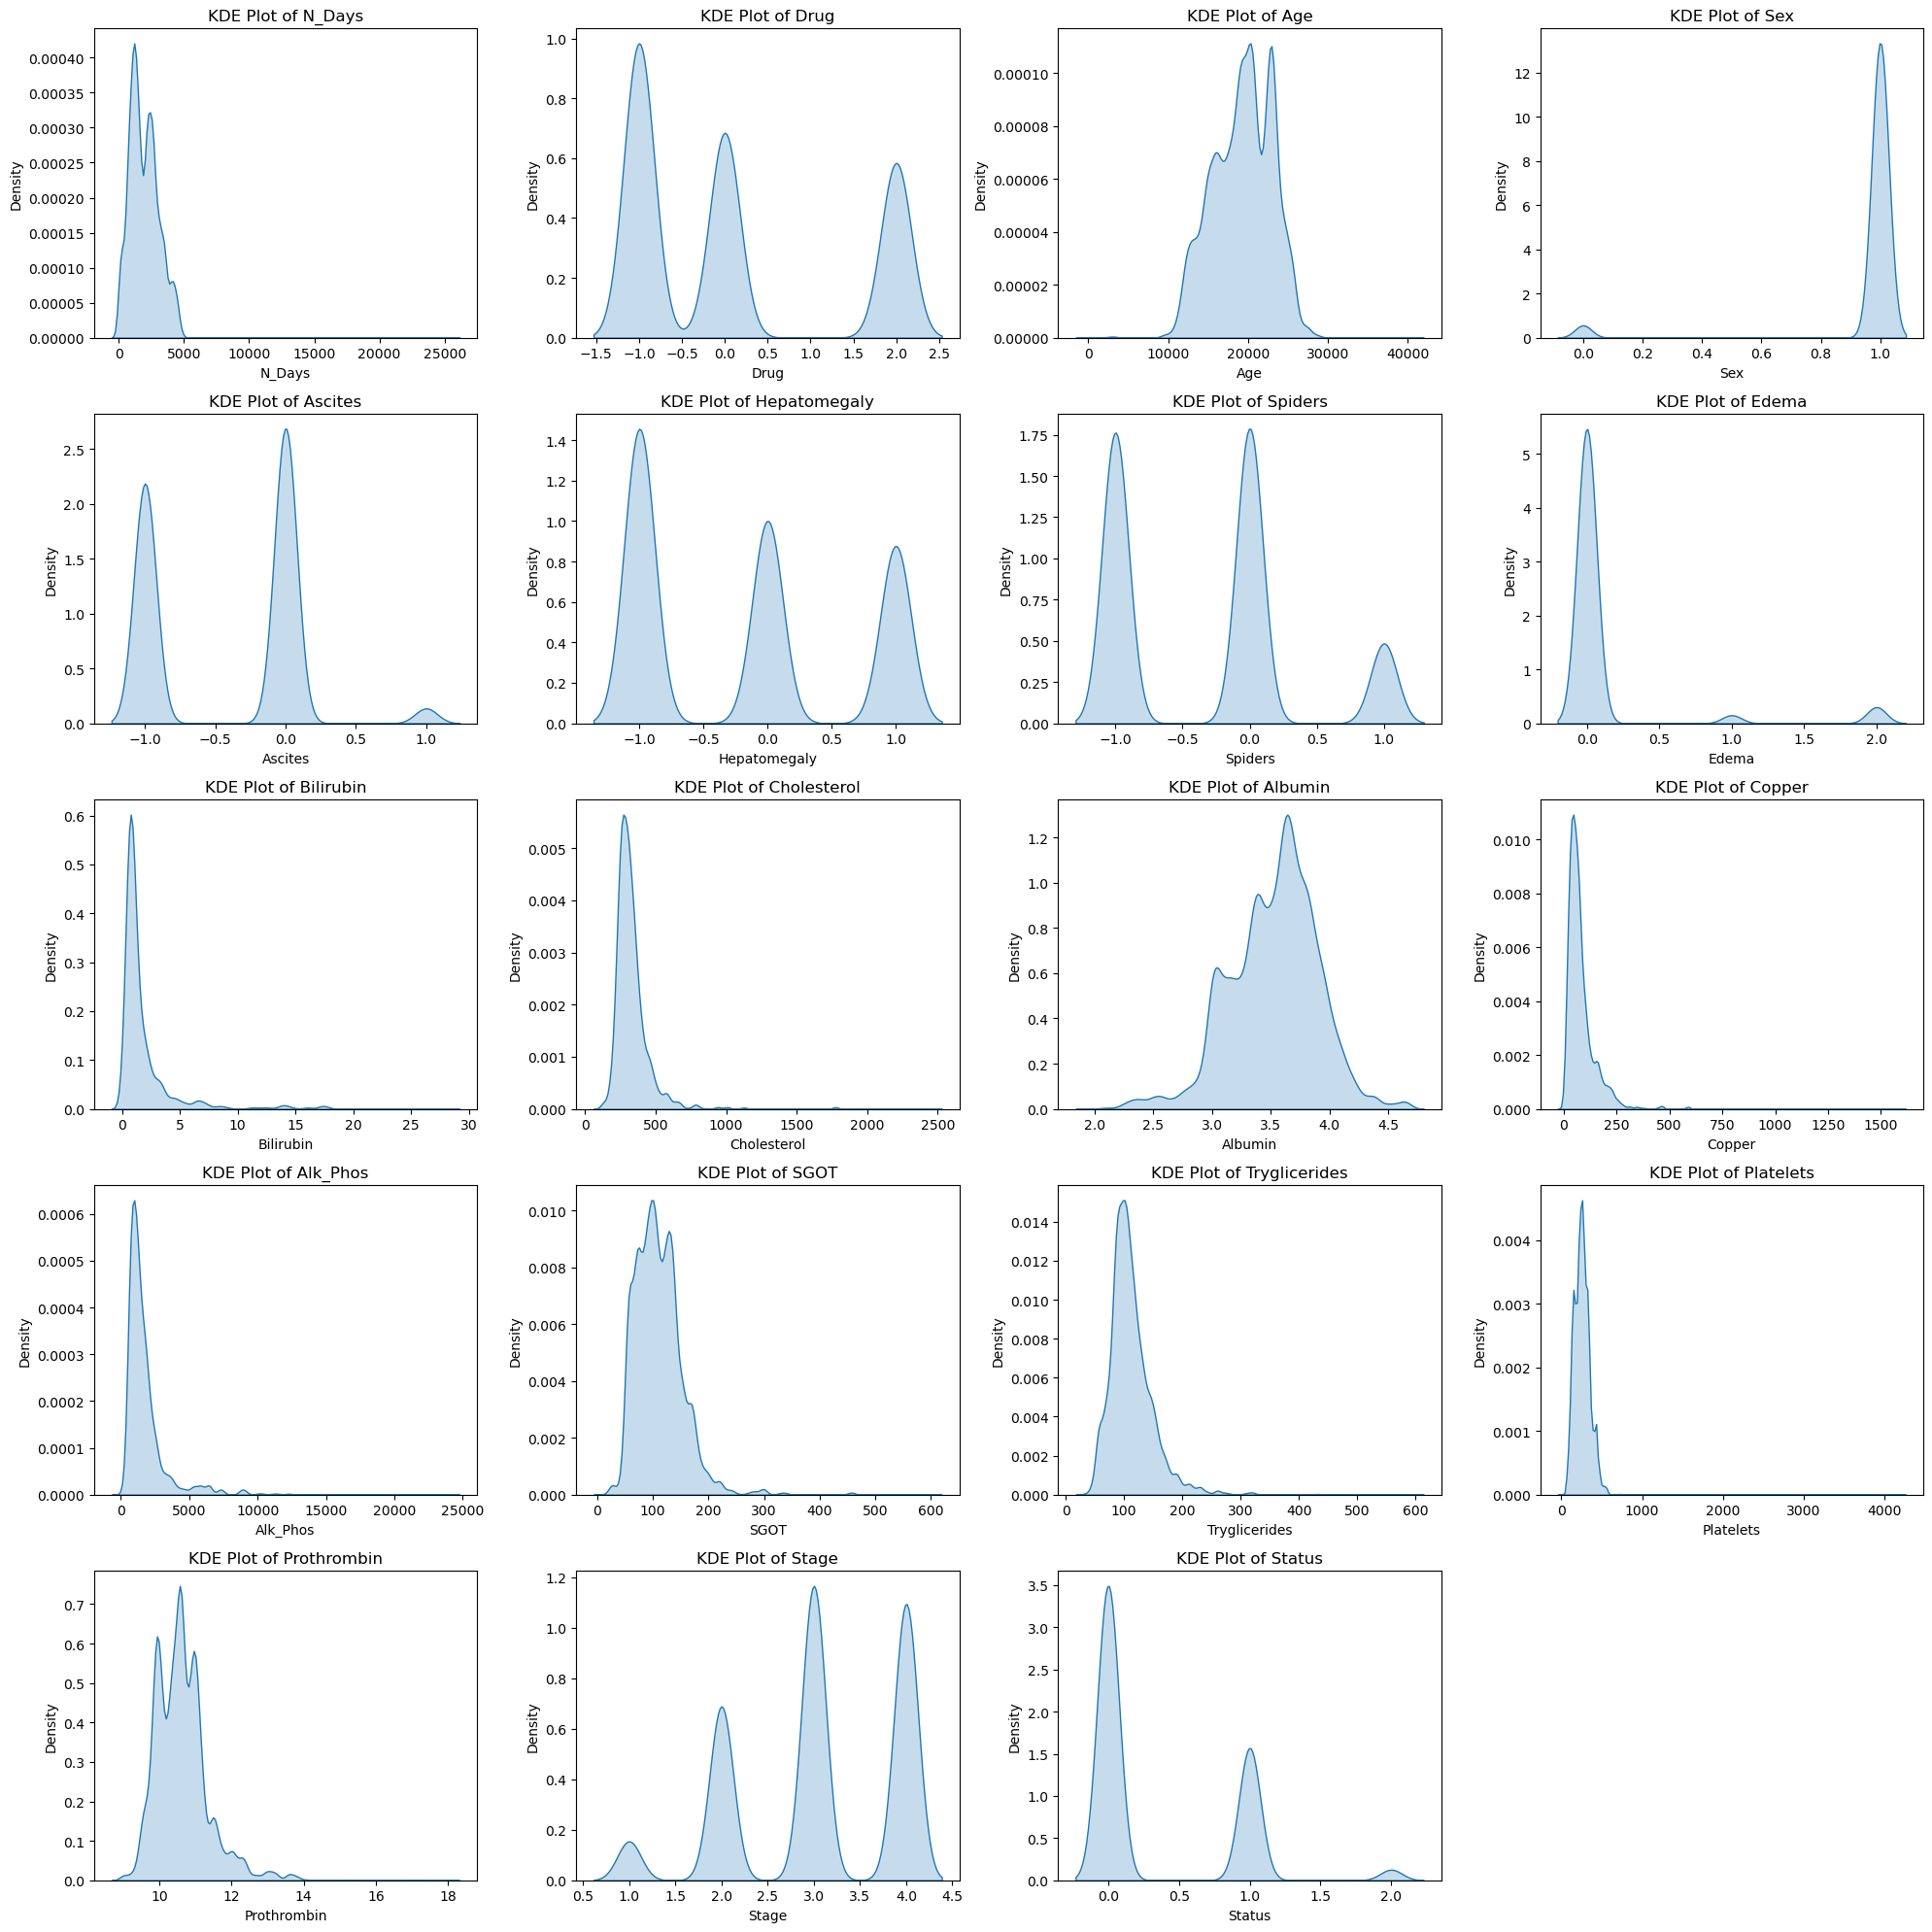

In [41]:
# prompt: can you loop over the cols and create the kde plot for each . create a subplot

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'processable_data' is your DataFrame and numerical_cols are defined
plt.figure(figsize=(20, 20))

for i, col in enumerate(processable_data.columns):
    plt.subplot(5, 4, i + 1)  # Adjust subplot grid as needed
    sns.kdeplot(processable_data[col], shade=True)
    plt.title(f'KDE Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [42]:
X = processable_data.drop('Status',axis=1)
y = processable_data['Status']

In [43]:
X.shape , y.shape

((15000, 18), (15000,))

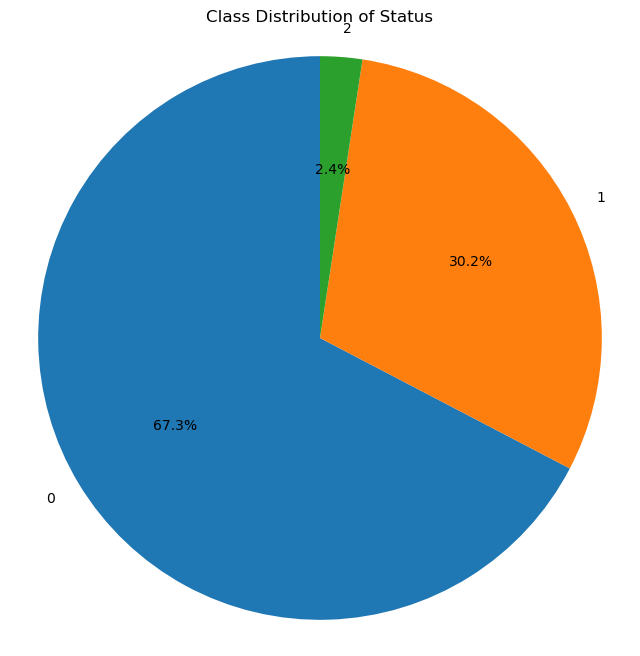

In [44]:
# prompt: can  you check for class imbalances in processable data using piechart . target is Status

import matplotlib.pyplot as plt
# Count occurrences of each class in the 'Status' column
status_counts = processable_data['Status'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution of Status')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [45]:

scaler = StandardScaler()

# Fit and transform the numerical features in the training data
processable_data[numerical_cols] = scaler.fit_transform(processable_data[numerical_cols])


In [46]:
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix

# # Assuming X and y are defined as in your previous code
# X = processable_data.drop('Status', axis=1)
# y = processable_data['Status']

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and train an SVM classifier
# svm_classifier = SVC(kernel='linear', C=1)  # You can experiment with different kernels and C values
# svm_classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = svm_classifier.predict(X_test)

# # Evaluate the model
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))


Doing stacking with 3 parameters to determine the efficiency

In [47]:
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# cat = CatBoostClassifier(verbose=0, random_state=42)
# # rf = RandomForestClassifier(random_state=42)


In [48]:
# # Define the estimators for stacking
# estimators = [
#     ('xgb', xgb),
#     ('cat', cat),
#     ('rf', rf)
# ]

# # Initialize the StackingClassifier
# stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# # Fit the stacking classifier
# stacking_classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred_stacking = stacking_classifier.predict(X_test)

# # Evaluate the stacking model
# print("Stacking Classifier:")
# print(classification_report(y_test, y_pred_stacking))
# print(confusion_matrix(y_test, y_pred_stacking))
